In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
# %matplotlib inline
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('WIPRO.csv')

#print the head
df.head()

,timestamp,open,high,low,close,adjusted close,volume,dividend amount
0,2019-01-17,330.05,339.80,311.35,335.40,335.40,37169582,0.0
1,2019-01-11,326.10,332.60,322.30,328.70,328.70,12614475,0.0
2,2019-01-04,331.00,333.80,319.65,324.45,324.45,12905687,0.0
3,2018-12-28,322.70,332.90,319.35,330.05,330.05,13889512,0.0
4,2018-12-21,335.95,342.25,320.75,322.10,322.10,23113325,0.0


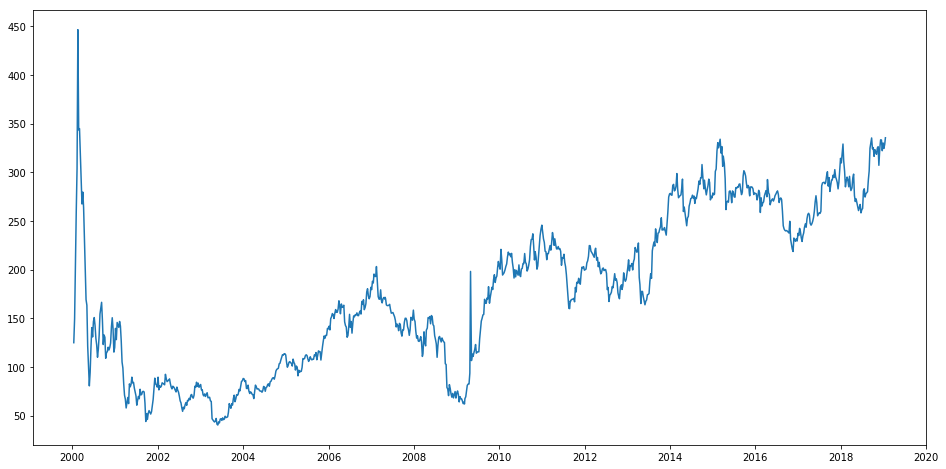

In [2]:
#setting index as date
df['timestamp'] = pd.to_datetime(df.timestamp,format='%Y-%m-%d')
df.index = df['timestamp']
df = df[:1000]
df = df[df['close']!=0]
#plot
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='Close Price history')
plt.show()

In [3]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['timestamp', 'close'])
for i in range(0,len(data)):
    new_data['timestamp'][i] = data['timestamp'][i]
    new_data['close'][i] = data['close'][i]

#setting index
new_data.index = new_data.timestamp
new_data.drop('timestamp', axis=1, inplace=True)

#creating train and test sets
# new_data['SMA_50'] = new_data['close'].rolling(window=50).mean()
# new_data = new_data.dropna()
dataset = new_data.values

Using TensorFlow backend.
/home/shivanshu/miniconda3/envs/env1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
train = dataset[0:650,:]
valid = dataset[650:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
# scaled_data

/home/shivanshu/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_temp = np.array(x_train)
x_temp.shape

(590, 60)

In [6]:
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(590, 60, 1)

In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 44s - loss: 0.0028


In [14]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
inputs.shape

(387, 1)

In [15]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price

array([[175.79541],
       [170.13481],
       [168.30717],
       [179.1316 ],
       [185.93326],
       [183.02716],
       [183.60179],
       [194.60492],
       [192.76906],
       [188.28786],
       [188.00992],
       [193.84537],
       [201.13823],
       [209.95976],
       [201.89082],
       [202.02092],
       [203.0662 ],
       [205.7513 ],
       [201.05698],
       [206.55492],
       [211.71558],
       [223.10507],
       [223.66068],
       [219.15388],
       [217.77278],
       [225.73764],
       [196.91312],
       [181.46817],
       [165.03232],
       [173.15097],
       [179.76483],
       [177.32649],
       [171.89877],
       [165.92598],
       [166.56358],
       [168.32277],
       [172.97275],
       [174.48581],
       [174.79326],
       [184.29079],
       [194.24757],
       [192.39006],
       [213.84387],
       [225.12073],
       [229.2294 ],
       [224.1911 ],
       [237.72781],
       [235.52484],
       [227.34491],
       [234.83829],


In [16]:
new_x_test = inputs[0:60,0]
predicted_prices = []
# new_x_test.shape
def input_test(new_x_test, predicted_value=None):
    new_x_test = new_x_test[1:60]
    new_x_test = np.append(new_x_test, predicted_value)
    return new_x_test
    
for i in range(30):
    new_x_test = np.array(new_x_test)
    new_x_test = np.reshape(new_x_test, (-1,new_x_test.shape[0],1))
    predicted_closing_price = model.predict(new_x_test)
    pcp = scaler.inverse_transform(predicted_closing_price)
    predicted_prices.append(list(pcp))
    new_x_test = np.reshape(new_x_test, 60)
    new_x_test = input_test(new_x_test, predicted_closing_price)
    
predicted_prices
# new_x_test = np.reshape(new_x_test, (-1,new_x_test.shape[0],1))
# new_x_test = np.reshape(new_x_test, 60)
# new_x_test.shape
# temp_new_closing_price = np.reshape(new_closing_price, (1,1,1))
# temp_new_closing_price
# new_closing_price = scaler.inverse_transform(new_closing_price)
# list(new_x_test).extend(list(scaler.transform(new_closing_price)))
# new_x_test
# closing_price
# rms=np.sqrt(np.mean(np.power((valid-closing_price-40),2)))
# rms

[[array([175.79541], dtype=float32)],
 [array([172.99545], dtype=float32)],
 [array([171.754], dtype=float32)],
 [array([171.4624], dtype=float32)],
 [array([171.83148], dtype=float32)],
 [array([172.55612], dtype=float32)],
 [array([173.3535], dtype=float32)],
 [array([174.00308], dtype=float32)],
 [array([174.36693], dtype=float32)],
 [array([174.39201], dtype=float32)],
 [array([174.09798], dtype=float32)],
 [array([173.55556], dtype=float32)],
 [array([172.86142], dtype=float32)],
 [array([172.11433], dtype=float32)],
 [array([171.39734], dtype=float32)],
 [array([170.767], dtype=float32)],
 [array([170.25014], dtype=float32)],
 [array([169.8467], dtype=float32)],
 [array([169.5363], dtype=float32)],
 [array([169.28677], dtype=float32)],
 [array([169.06245], dtype=float32)],
 [array([168.83093], dtype=float32)],
 [array([168.5677], dtype=float32)],
 [array([168.25826], dtype=float32)],
 [array([167.89804], dtype=float32)],
 [array([167.49062], dtype=float32)],
 [array([167.0451], d

/home/shivanshu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


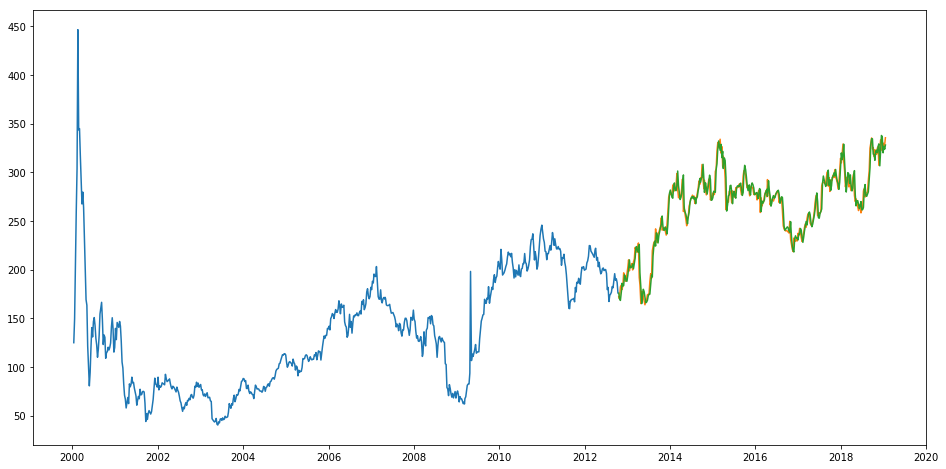

In [17]:
#for plotting
train = new_data[:650]
valid = new_data[650:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])

In [20]:
valid['close'].tolist()

[172.275,
 170.05,
 182.3,
 184.375,
 179.55,
 183.425,
 196.625,
 190.1,
 187.975,
 189.725,
 196.025,
 201.825,
 209.975,
 198.675,
 203.825,
 203.8,
 206.2,
 199.625,
 207.975,
 210.85,
 222.675,
 220.475,
 217.85,
 218.575,
 227.3,
 191.9,
 184.525,
 165.1,
 177.625,
 177.5,
 172.0,
 168.1,
 163.825,
 167.45,
 168.775,
 174.2,
 174.5,
 175.475,
 187.8,
 195.7,
 190.975,
 219.35,
 223.575,
 228.25,
 224.1,
 241.8,
 234.25,
 227.75,
 237.45,
 237.925,
 241.475,
 244.125,
 253.2,
 240.55,
 241.275,
 240.775,
 243.15,
 238.975,
 235.4,
 246.9,
 259.375,
 274.45,
 277.55,
 278.3,
 276.675,
 276.35,
 286.425,
 287.525,
 280.825,
 281.9,
 285.775,
 298.625,
 282.675,
 273.8,
 276.025,
 276.7,
 284.05,
 292.925,
 259.625,
 264.25,
 256.975,
 251.4,
 245.0,
 253.1,
 254.575,
 265.2,
 268.4,
 272.975,
 273.375,
 276.425,
 273.525,
 275.525,
 268.0,
 274.025,
 272.975,
 278.475,
 282.625,
 290.95,
 287.5,
 294.2,
 294.3,
 307.875,
 292.35,
 282.95,
 291.825,
 281.85,
 276.725,
 281.95,
 286.0

In [18]:
valid.to_csv("prediction.csv")